# Introduction
* Based on P2P dataset of loan data. We will attempt an Arima forecast to predict future avg loan amounts
*  Model Identification. Use plots and summary statistics to identify trends, seasonality, and autoregression elements to get an idea of the amount of differencing and the size of the lag that will be required.
* Parameter Estimation. Use a fitting procedure to find the coefficients of the regression model.
* Model Checking. Use plots and statistical tests of the residual errors to determine the amount and type of temporal structure not captured by the model.


### Imports
Import libraries and write settings here.

In [14]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2
#date
import datetime

#
import itertools


# Visualizations
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import seaborn as sns

# machine learning
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score

# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected=True)

# import cufflinks as cf
# cf.go_offline(connected=True)
# cf.set_config_file(theme='white')

In [15]:
df= pd.read_csv("loan.csv", low_memory=False)

# PreProcessing


In [16]:
df['issue_d'] = pd.to_datetime(df['issue_d'])

In [17]:
df = df[["funded_amnt", "term", "int_rate", "installment", "grade", "application_type", "sub_grade", "emp_length", "home_ownership",
         "annual_inc", "verification_status", "issue_d", "loan_status", "purpose", "addr_state", "dti", "open_acc", "tot_cur_bal", "all_util", "num_sats", "mort_acc", 
         "pct_tl_nvr_dlq", "total_acc", "last_pymnt_d"]].copy()

In [18]:
df['month'] = pd.DatetimeIndex(df['issue_d']).month

In [19]:
#sort dates by dates in ascending order, inplace is true
df.sort_values(by=['issue_d'], inplace=True, ascending=True)

In [20]:
#Get teh columns we want to look at: the funded amount, the issue_d (date) and teh month extrapolation of the date I created
#the month extrapolation may not be necessary
forecast_df = df[['funded_amnt','issue_d']]

In [21]:
#Group by the issue date, aggregate the laons for each month and calculate teh mean for that month
forecast_df = df.groupby('issue_d').agg({'funded_amnt': ['mean']})

In [22]:
forecast_df = forecast_df.reset_index()

In [23]:
#set date as index, makes plotting and forecasting easier

forecast_df = forecast_df.set_index('issue_d')

In [24]:
#Running the first 5 rows of the dataset
forecast_df.head()

,funded_amnt
,mean
issue_d,
2007-06-01,3827.083333
2007-07-01,5271.428571
2007-08-01,6602.702703
2007-09-01,7036.792453
2007-10-01,6503.571429


## Plotting the Loan Amount Data

* No distinguable pattern appears aside from a an upward trend in the early years. Thereafter, the average loan amount leveled out in the outer years. 

* Examningg some of the years

* IS there Seasonal Activity?

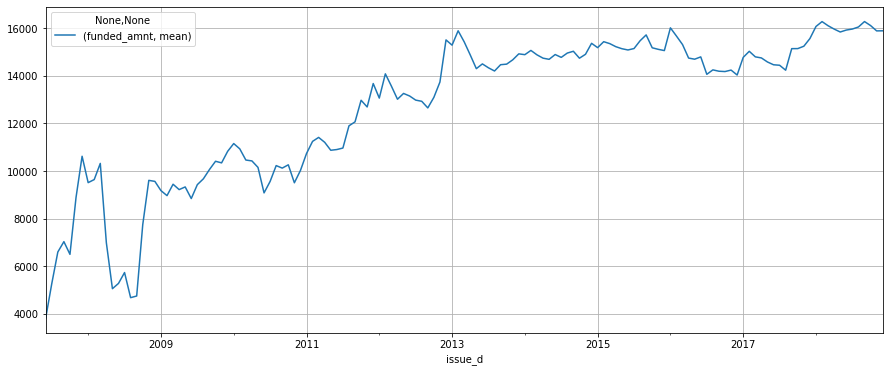

In [25]:
#data is plotted as a time series with month along the x-axis and loan figures(mean) on the 
forecast_df.plot(figsize=(15,6), grid=True)
plt.show()

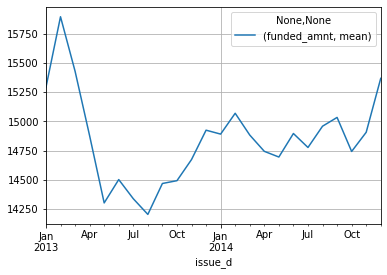

In [26]:
# ONE YEAR VIEW 2013-2014
from datetime import datetime
start_date = datetime(2013,1, 1)
end_date = datetime(2014, 12, 1)
forecast_df[(start_date <=forecast_df.index) & (forecast_df.index <= end_date)].plot(grid=True)

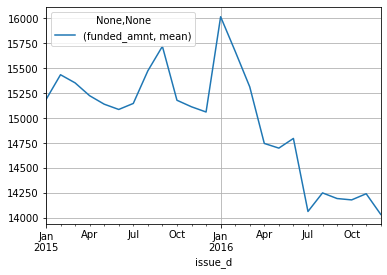

In [27]:
# ONE YEAR VIEW 2015-2016
from datetime import datetime
start_date = datetime(2015,1, 1)
end_date = datetime(2016, 12, 1)
forecast_df[(start_date <=forecast_df.index) & (forecast_df.index <= end_date)].plot(grid=True)

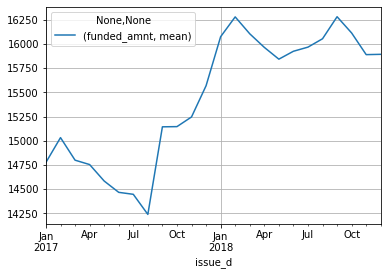

In [28]:
# ONE YEAR VIEW 2017-2018
from datetime import datetime
start_date = datetime(2017,1, 1)
end_date = datetime(2018, 12, 1)
forecast_df[(start_date <=forecast_df.index) & (forecast_df.index <= end_date)].plot(grid=True)

C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\ppage\Anaconda3\envs\TF\lib\site

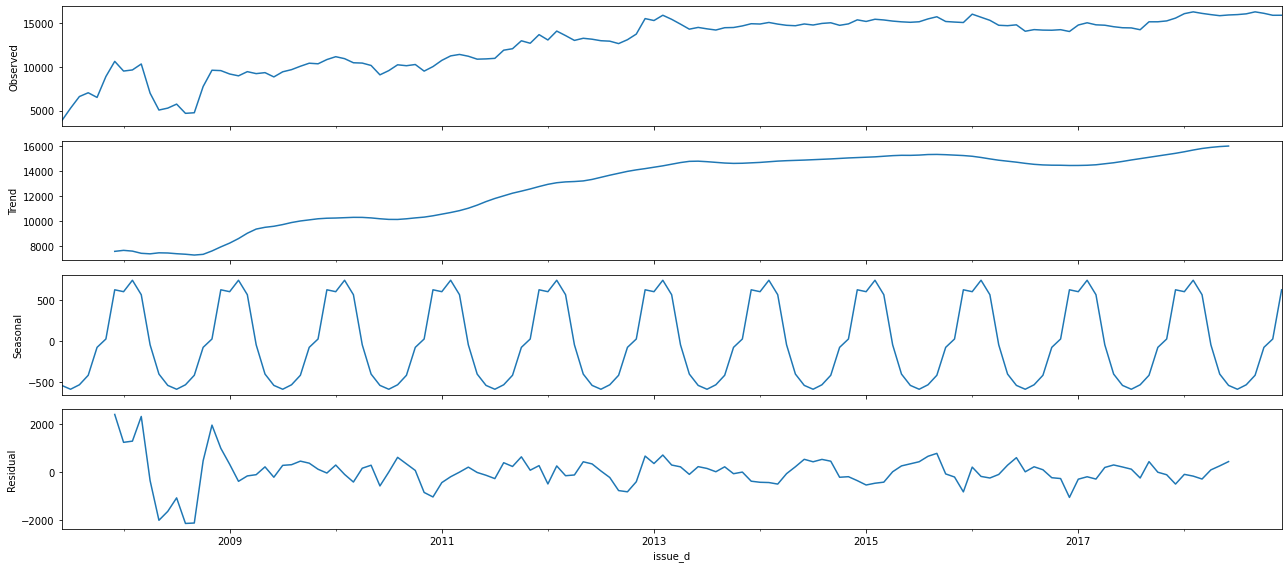

In [29]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(forecast_df, model='additive')
fig = decomposition.plot()
plt.show()


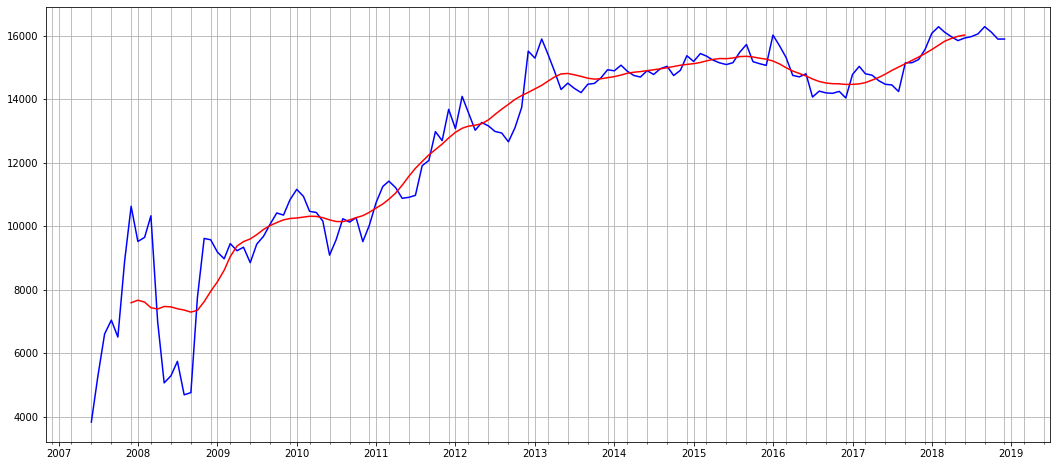

In [30]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()
ax.grid(True)
year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)
year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%m')
ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)
plt.plot(forecast_df.index, forecast_df[('funded_amnt', 'mean')], c='blue')
plt.plot(decomposition.trend.index, decomposition.trend, c='red')

In [31]:
# from pandas.plotting import autocorrelation_plot, lag_plot
# from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

# ARIMA MODE
* Autoregressive Integrated Moving Average
* ARIMA models are denoted with the notation ARIMA(p, d, q). 
* These three parameters account for seasonality, trend, and noise in data:

In [32]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


* This step is parameter Selection for our  ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

* The Akaike information criterion is an estimator of out-of-sample prediction error and thereby relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Choose the one withe lowest AIC
* Very Time Intensive, may not be necessary

In [33]:
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(y,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

In [34]:
#Fit ARIMA(5,1,0). This sets teh lag values to 5 for autoregression, uses a difference order of 1 to make the
#the time series stationary and uses a moving average model of 0.

from statsmodels.tsa.arima_model import ARIMA

 
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
series = forecast_df
# fit model
model = ARIMA(series, order=(1,1,0))
model_fit = model.fit()
#disp=0 turns off debug information
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:     D.funded_amnt_mean   No. Observations:                  138
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1093.720
Method:                       css-mle   S.D. of innovations            669.456
Date:                Thu, 23 Jul 2020   AIC                           2193.441
Time:                        13:39:07   BIC                           2202.222
Sample:                    07-01-2007   HQIC                          2197.009
                         - 12-01-2018                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       89.2928     68.553      1.303      0.195     -45.069     223.654
ar.L1.D.funded_amnt_mean     0.1698      0.085      2.002      0.047       0.004       0.

C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


# Rolling Forecast ARIMA Model

* Use the predict() function on teh ARIMAResults objec to make predictions. Accepts the index of the time steps to make predictions as arguments

* Running the example prints the prediction and expected value each iteration.

* We can also calculate a final mean squared error score (MSE) for the predictions, providing a point of comparison for other ARIMA configurations.

* A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale.

* Using the forecast() function, which performs a one-step forecast using the model.

In [35]:
series = forecast_df
X = forecast_df.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

In [36]:
#Forecast and plot
result = pd.DataFrame({'training': test.ravel()[0:10], 'predictions': model_fit.forecast(10)[0]})

In [37]:
result.head()

,training,predictions
0,15185.933717,15967.512074
1,15435.781447,16054.322679
2,15354.459646,16143.193986
3,15225.705676,16232.415247
4,15140.835240,16321.695938


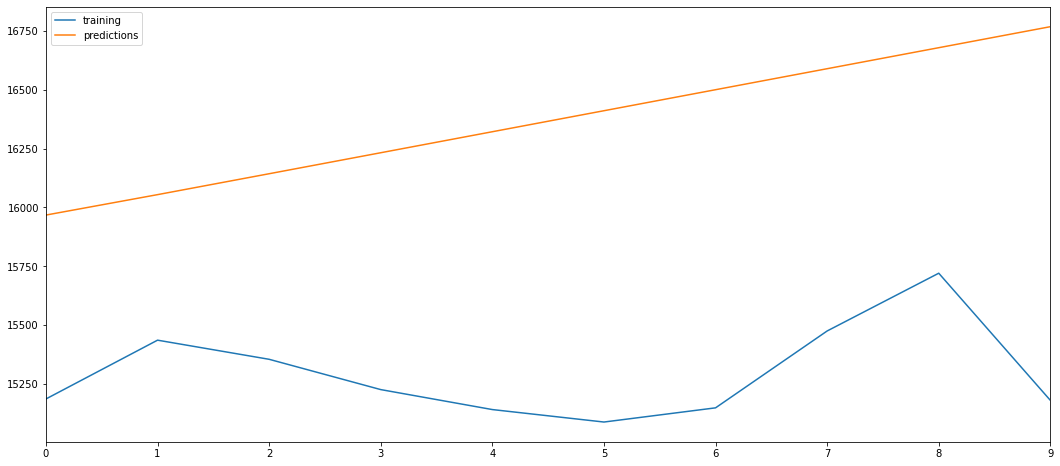

In [38]:
result.plot()

predicted=15560.009270, expected=15185.933717
predicted=15257.350564, expected=15435.781447
predicted=15587.085055, expected=15354.459646
predicted=15443.637172, expected=15225.705676
predicted=15303.788943, expected=15140.835240
predicted=15225.080145, expected=15087.841847
predicted=15176.381899, expected=15148.135416
predicted=15256.949549, expected=15474.875996
predicted=15634.430685, expected=15720.358926
predicted=15865.982580, expected=15180.057988
predicted=15176.793293, expected=15114.503730
predicted=15196.190314, expected=15062.367228
predicted=15145.124399, expected=16016.912810
predicted=16289.013732, expected=15670.678489
predicted=15707.507960, expected=15314.355885
predicted=15344.401460, expected=14747.427399
predicted=14732.360755, expected=14700.519311
predicted=14777.713248, expected=14797.415125
predicted=14900.451739, expected=14065.624279
predicted=14013.260052, expected=14251.754410
predicted=14364.826781, expected=14195.295623
predicted=14264.357004, expected=1

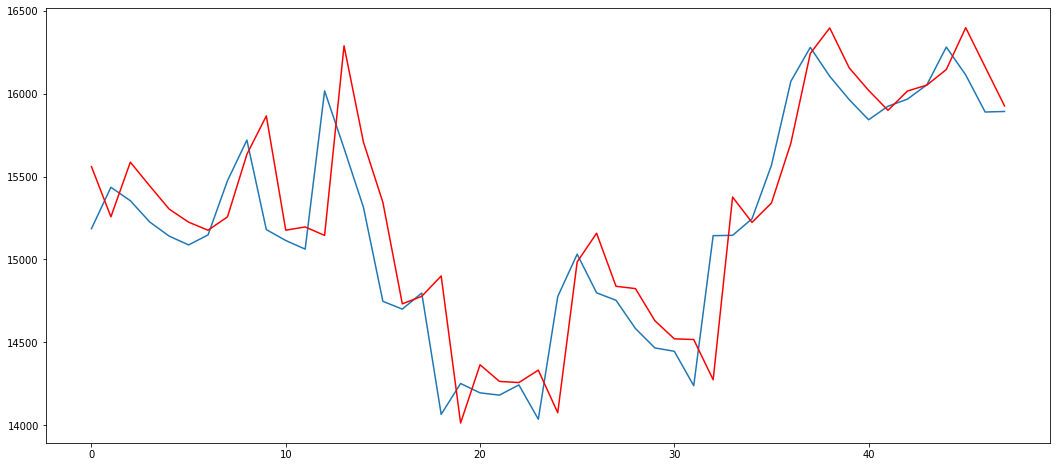

In [39]:
from sklearn.metrics import mean_squared_error
 
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
series = forecast_df
X = forecast_df.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(1,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()